In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from mpl_toolkits.mplot3d import Axes3D
from dadapy.feature_weighting import FeatureWeighting
import time

%matplotlib inline

%load_ext autoreload
%autoreload 2

/home/romi/anaconda3/envs/dii_ms_test1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from  matplotlib import font_manager
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.weight'] = 'light'
plt.rcParams['font.size'] = 13
plt.rcParams["axes.labelweight"] = "light"
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.linewidth"] = 0.5

# Note
- Weights are referred to as "gammas" in this notebook

# Load the collective variables
- all 4278 heavy atom pairwise distances as groundtruth
- ten other collective variables as input

In [3]:
# all heavy atom distances
dist = np.load('./cln025_groundtruth_CVs.npy')
dist=dist[:,1:] # the first column is the time step
dist=dist[-40000:] # cut away the equilibration time

dist.shape

(40000, 4278)

In [4]:
inputs_classic = np.loadtxt('./cln025_input_CVs.txt')
inputs_classic = inputs_classic[-40000:,] # cut away equilibration

header_classic=['rgyr', 'antibetasheet', 'alphahelical', 'numhb_bb', 'numhb_sc', 'numhb_mixed', 'numhydroph', 'pc1', 'pc2', 'pc_res']
header_classic = np.array(header_classic)

inputs_classic.shape

(40000, 10)

### Make index combination for full combinatoric search

In [5]:
indices = []
ind=[]
for i in range(10):
    ind.append(i)
ind = np.array(ind)
indices.append(ind[:,np.newaxis])
for i in range(2,inputs_classic.shape[1]+1):
    ind=np.array(list(itertools.combinations(range(0,inputs_classic.shape[1]),i)))
    indices.append(ind)
    print("the number of combinations of ",i, " CVs is", len(ind))

the number of combinations of  2  CVs is 45
the number of combinations of  3  CVs is 120
the number of combinations of  4  CVs is 210
the number of combinations of  5  CVs is 252
the number of combinations of  6  CVs is 210
the number of combinations of  7  CVs is 120
the number of combinations of  8  CVs is 45
the number of combinations of  9  CVs is 10
the number of combinations of  10  CVs is 1


# Optimize DII for 1429 points from the full trajetory
- Full combinatoric search possible
- The subsampling prevents autocorrelations
- The below calculation takes 2 hours on an average workstation. Uncomment, if you wish to calculate. Otherwise run the cells in order as they are, to use our precalculated results

In [ ]:
# start=time.time()
# ins_classic = inputs_classic[::28]
# dis = dist[::28]

# imbalances_opt=[]
# gammas_opt = []
# #for j in range(len(indices)):
# for j in range(0, len(indices)):
#     imb=[]
#     gams=[]
#     print("for ", j+1, " CVs there are ", len(indices[j]), " combinations")
#     for i in indices[j]:
#         print("optimizing combi ", i, " for ", j, " CVs" )  
#         target_object = FeatureWeighting(dis)
#         inputs_object = FeatureWeighting(ins_classic[:,i])
#         w = inputs_object.return_weights_optimize_dii(
#             target_data = target_object,
#             n_epochs = 80,
#             constrain = False,
#             initial_weights = None,
#             lambd = None,
#             learning_rate = None,
#             l1_penalty = 0.0,
#             decaying_lr = "exp"
#         )
#         dii = inputs_object.history["dii_per_epoch"]
#         weights = inputs_object.history["weights_per_epoch"]
#         imb.append(dii)
#         gams.append(weights)
#     imbalances_opt.append(imb)
#     gammas_opt.append(gams)
# end=time.time()
# print(end-start)

# # np.save('./ANALYSIS/FULL_COMBINATORICS/imbalances_opt_cut_eq.npy', np.array(imbalances_opt, dtype=object))
# # np.save('./ANALYSIS/FULL_COMBINATORICS/gammas_opt_cut_eq.npy', np.array(gammas_opt, dtype=object))

In [6]:
imbalances_opt = np.load('./ANALYSIS/FULL_COMBINATORICS/imbalances_opt_cut_eq.npy',allow_pickle=True)
gammas_opt = np.load('./ANALYSIS/FULL_COMBINATORICS/gammas_opt_cut_eq.npy',allow_pickle=True)

#### Select best training results

In [7]:
# pick out for each optimization run the lowest imbalance during the epochs, and the according weights (gammas)

imbalances_opt_end = []
gammas_opt_end = []
for i, imbi in enumerate(imbalances_opt):
    imb = []
    gamm = []
    for jj, j in enumerate(imbi):
        #imb.append(j[-1])
        imb.append(np.nanmin(j))
        gamm.append(gammas_opt[i][jj][np.nanargmin(j)])
    imbalances_opt_end.append(imb)
    gammas_opt_end.append(gamm)
    
# now pick out from all the singlets, duplets, etc the lowest one, and according gamma

lowimb = []
lowimb_index = []
lowimb_gamma = []
lowimb_tuple = []
for i, imb in enumerate(imbalances_opt_end):
    lowimb.append(np.min(imb))
    lowimb_index.append(np.argmin(imb))
    lowimb_gamma.append(gammas_opt_end[i][np.argmin(imb)])
    lowimb_tuple.append(indices[i][np.argmin(imb)])

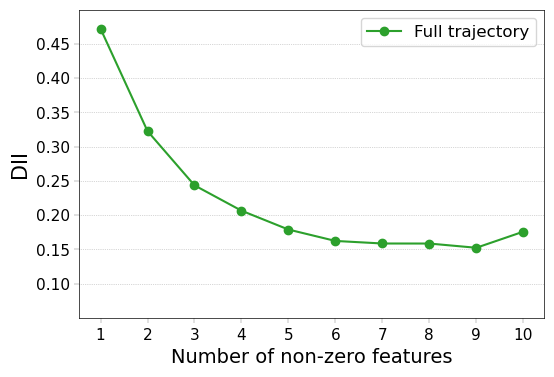

In [8]:
fig = plt.figure(figsize=(6,4))
# Full optimization
plt.plot(range(1, len(lowimb)+1), lowimb, "-o", label="Full trajectory", linewidth=1.5, color = "tab:green")

plt.xlabel("Number of non-zero features",fontsize=14)
plt.ylabel("DII")
plt.ylim(0.05,0.5)
plt.grid(visible=True, which='major', axis='both')
plt.legend(fontsize=12)
plt.xticks(range(1,11), fontsize=11)
plt.yticks(np.arange(0.1,0.5,0.05), fontsize=11)
plt.minorticks_off()
plt.tick_params(axis='both', which='major', width=0.176)
plt.grid(visible=False)
plt.grid(visible=True, which='major', axis='y', linestyle=':', linewidth=0.5)

In [9]:
# The features leading to the lowest imbalances
lowimb_tuple

[array([1]),
 array([7, 8]),
 array([0, 7, 8]),
 array([0, 7, 8, 9]),
 array([0, 2, 7, 8, 9]),
 array([0, 2, 6, 7, 8, 9]),
 array([0, 1, 2, 6, 7, 8, 9]),
 array([0, 2, 3, 4, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]

In [10]:
# The relative weights of the above features
lowimb_gamma

[array([2.04]),
 array([51.36, 67.41]),
 array([14.51, 51.11, 67.67]),
 array([13.7 , 51.87, 67.33, 10.24]),
 array([14.44,  5.21, 52.02, 67.2 ,  9.72]),
 array([1.37e+01, 3.37e+00, 1.61e-02, 5.15e+01, 6.73e+01, 1.05e+01]),
 array([1.37e+01, 2.06e+00, 3.37e+00, 1.77e-02, 5.15e+01, 6.73e+01,
        1.05e+01]),
 array([1.38e+01, 3.40e+00, 1.66e-01, 1.94e-01, 1.56e-02, 5.16e+01,
        6.73e+01, 1.05e+01]),
 array([1.38e+01, 1.96e+00, 3.35e+00, 2.01e-01, 9.88e-02, 1.38e-02,
        5.16e+01, 6.73e+01, 1.05e+01]),
 array([1.37e+01, 2.05e+00, 3.37e+00, 5.04e-01, 9.87e-01, 4.56e-01,
        3.23e-02, 5.15e+01, 6.73e+01, 1.05e+01])]

### plot the optimization of the best 5plet

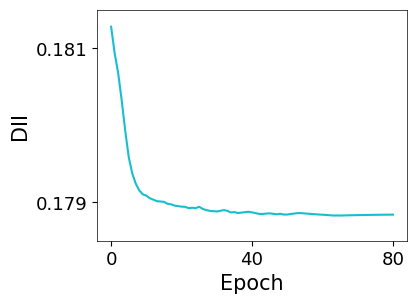

In [11]:
# plot the optimization for the best 5plet
tups = 4 # best 5 plet

fig = plt.figure(figsize=(4,3))
plt.plot(imbalances_opt[tups][lowimb_index[tups]], color="tab:cyan")
plt.xticks([0,40,80])
plt.yticks([0.181,0.179]) #5
plt.ylim((0.1785,0.1815))   #5
plt.ylabel("DII")
plt.xlabel("Epoch")
plt.minorticks_off()
plt.tick_params(axis='y', which='minor', width=0.176)
plt.show()

# Block transferability analysis

### Divide data into 4 blocks of 10000 points

In [12]:
blocked_data = []
blocked_groundtruth = []
blocksize = inputs_classic.shape[0]//4
print("blocksize: ",blocksize)
for j in range(4):
    print("block ", j)
    data_cut = inputs_classic[(j*blocksize):((j+1)*blocksize)] # consecutive blocks
    dis = dist[(j*blocksize):((j+1)*blocksize)]
    blocked_data.append(data_cut)
    blocked_groundtruth.append(dis)


blocksize:  10000
block  0
block  1
block  2
block  3


In [13]:
# if these blocks are subsampled by 7, we get samples of 1428 points, (almost) like the above optimized 1429
10000//7

1428

### Load/Calculate the training set 
- Optimize DII and weights for each block section
- Each block is subsampled into 7 sections, such that each section has 1428 points
- The below calculation takes a full day on an average workstation. Uncomment, if you wish to calculate. Otherwise run the cells in order as they are, to use our precalculated results

In [ ]:
# imb_opt_listb=[]
# gamma_opt_listb=[]

# for b in range(len(blocked_data)):
#     print("Block ", b, " optimization")
#     ins_classic = blocked_data[b][::7] # Use every 7th point to be sure to decorrelate
#     dis = blocked_groundtruth[b][::7]

#     imbalances_opt=[]
#     gammas_opt = []
#     #for j in range(len(indices)):
#     for j in range(0, len(indices)):
#         imb=[]
#         gams=[]
#         print("for ", j+1, " CVs there are ", len(indices[j]), " combinations")
#         for i in indices[j]:
#             print("optimizing combi ", i, " for ", j+1, " CVs" )   
#             target_object = FeatureWeighting(dis)
#             inputs_object = FeatureWeighting(ins_classic[:,i])
#             w = inputs_object.return_weights_optimize_dii(
#                 target_data = target_object,
#                 n_epochs = 80,
#                 constrain = False,
#                 initial_weights = None,
#                 lambd = None,
#                 learning_rate = None,
#                 l1_penalty = 0.0,
#                 decaying_lr = "exp"
#             )
#             dii = inputs_object.history["dii_per_epoch"]
#             weights = inputs_object.history["weights_per_epoch"]
#             imb.append(dii)
#             gams.append(weights)
#         imbalances_opt.append(imb)
#         gammas_opt.append(gams)
#     imb_opt_listb.append(imbalances_opt)
#     gamma_opt_listb.append(gammas_opt)

# # np.save('./ANALYSIS/FULL_COMBINATORICS_BLOCK_CROSS_VAL/imbalances_opt.npy', np.array(imb_opt_listb, dtype=object))
# # np.save('./ANALYSIS/FULL_COMBINATORICS_BLOCK_CROSS_VAL/gammas_opt.npy', np.array(gamma_opt_listb, dtype=object))

In [14]:
imb_opt_listb = np.load('./ANALYSIS/FULL_COMBINATORICS_BLOCK_CROSS_VAL/imbalances_opt.npy',allow_pickle=True)
gamma_opt_listb = np.load('./ANALYSIS/FULL_COMBINATORICS_BLOCK_CROSS_VAL/gammas_opt.npy',allow_pickle=True)

#### Select best training results

In [15]:
# pick out for each optimization run the lowest imbalance during the epochs, and the according weights (gammas)
imbalances_opt_end_listb = []
gammas_opt_end_listb = []
for k, imbalances_opt in enumerate(imb_opt_listb):
    imbalances_opt_end = []
    gammas_opt_end = []
    gammas_opt=gamma_opt_listb[k]
    for i, imbi in enumerate(imbalances_opt):
        imb = []
        gamm = []
        for jj, j in enumerate(imbi):
            #imb.append(j[-1])
            imb.append(np.nanmin(j))
            gamm.append(gammas_opt[i][jj][np.nanargmin(j)])
        imbalances_opt_end.append(imb)
        gammas_opt_end.append(gamm)
    imbalances_opt_end_listb.append(imbalances_opt_end)
    gammas_opt_end_listb.append(gammas_opt_end)
    
# now pick out from all the singlets, duplets, etc the lowest one, and according gamma
lowimb_listb=[]
lowimb_index_listb=[]
lowimb_gamma_listb = []
lowimb_tuple_listb = []
for j, imbalances_opt_end in enumerate(imbalances_opt_end_listb):
    gammas_opt_end = gammas_opt_end_listb[j]
    lowimbb = []
    lowimb_indexb = []
    lowimb_gammab = []
    lowimb_tupleb = []
    for i, imb in enumerate(imbalances_opt_end):
        lowimbb.append(np.min(imb))
        lowimb_indexb.append(np.argmin(imb))
        lowimb_gammab.append(gammas_opt_end[i][np.argmin(imb)])
        lowimb_tupleb.append(indices[i][np.argmin(imb)])
    lowimb_listb.append(lowimbb)
    lowimb_index_listb.append(lowimb_indexb)
    lowimb_gamma_listb.append(lowimb_gammab)
    lowimb_tuple_listb.append(lowimb_tupleb) 

### Load/Calculate the test imbalances: 
- Use the feature tuples generated in the training blocks
- Apply to test block sections
- running this takes roughly 15 min

In [ ]:
# # Test set of blocks

# imbalances_test_list=[]
# all_blocks=[0,1,2,3]
# for trainblock in range(4):
#     print("analysis assiciated to training block ", trainblock+1)
#     mytestblocks = np.delete(all_blocks, trainblock)
#     imbalances_test3=[]
#     for j in mytestblocks:
#         print("start running test block ", j+1)
#         data_cut_ = blocked_data[j] # consecutive blocks
#         dis_ = blocked_groundtruth[j]
#         for k in range(7): #take every 7ths point
#             print("start running section ", (k+1))
#             data_cut = data_cut_[k::7]
#             dis = dis_[k::7]
#             target_B = FeatureWeighting(dis)
#             imb = []
#             for i, tupl in enumerate(lowimb_tuple_listb[trainblock]):  # take the tuple optimized in the training block
#                 data = data_cut[:,tupl] * lowimb_gamma_listb[trainblock][i] # take the weights optimized in the training block
#                 input_A = FeatureWeighting(data)
#                 im = input_A.return_dii(target_data = target_B, lambd=None)
#                 imb.append(im)
#             imbalances_test3.append(imb)
#     imbalances_test_list.append(imbalances_test3)
    
# # np.save('./ANALYSIS/FULL_COMBINATORICS_BLOCK_CROSS_VAL/imbalances_test.npy',imbalances_test_list)

In [16]:
imbalances_test_list = np.load('./ANALYSIS/FULL_COMBINATORICS_BLOCK_CROSS_VAL/imbalances_test.npy')

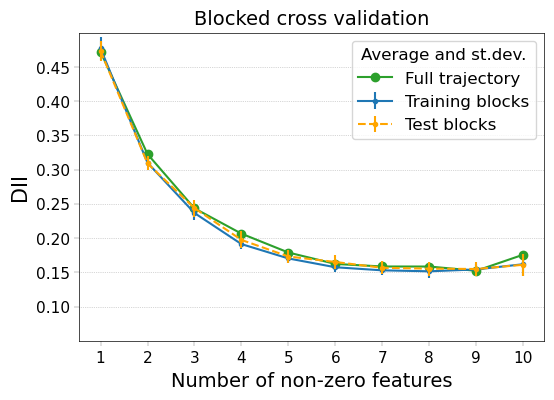

In [17]:
fig = plt.figure(figsize=(6,4))

# Block analysis: Training
plt.errorbar(range(1,11), np.mean(np.array(lowimb_listb),axis=0), np.std(np.array(lowimb_listb),axis=0), marker=".", linewidth=1.5, label="Training blocks")

# Full optimization
plt.plot(range(1, len(lowimb)+1), lowimb, "-o", label="Full trajectory", linewidth=1.5, color = "tab:green")

#Block analysis: Test
plt.errorbar(range(1,11), np.mean(imbalances_test_list,axis=(0,1)), np.std(imbalances_test_list,axis=(0,1)), color="orange", linestyle='--', marker='.', linewidth=1.5, label="Test blocks", zorder=8)

plt.title("Blocked cross validation",fontsize=14)
plt.xlabel("Number of non-zero features",fontsize=14)
plt.ylabel("DII")
plt.ylim(0.05,0.5)
plt.grid(visible=True, which='major', axis='both')
plt.legend(title="Average and st.dev.", fontsize=12, title_fontsize=12)
plt.xticks(range(1,11), fontsize=11)
plt.yticks(np.arange(0.1,0.5,0.05), fontsize=11)
plt.minorticks_off()
plt.tick_params(axis='both', which='major', width=0.176)
plt.grid(visible=False)
plt.grid(visible=True, which='major', axis='y', linestyle=':', linewidth=0.5)
plt.show()

# Find the free energy clusters in the full space and the space of the best 3 features
- It is possible to use the stored values for "best3" and "dis" or load them by uncommenting below cell, if this section is run independently

In [18]:
# Scale and save the best 3 variables
ins_classic = inputs_classic[::28]
best3 = ins_classic[:,lowimb_tuple[2]]*lowimb_gamma[2]
dis = dist[::28]

# np.savetxt('./FREE_ENERGY_CLUSTER/best3_scaled_rgyr_pc1_pc2_1429pt.npy', best3)
# np.save('./FREE_ENERGY_CLUSTER/dis_1429pt.npy', dis)

In [ ]:
# best3 = np.load('./FREE_ENERGY_CLUSTER/best3_scaled_rgyr_pc1_pc2_1429pt.npy')
# dis = np.load('./FREE_ENERGY_CLUSTER/dis_1429pt.npy')

## Best 3

### Intrinsic dimension and clustering in the space of the best 3 with DADApy

In [19]:
from dadapy import Data
from dadapy import plot as pl
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from scipy.interpolate import griddata, Rbf

In [20]:
# initialise a Data object
d_best3 = Data(best3, verbose=False)
# compute distances by setting the correct period
d_best3.compute_distances(maxk=min(best3.shape[0]-1, 10000))
# estimate the intrinsic dimension
d_best3.compute_id_2NN()

(2.846113454146031, 0.0, 0.12784041157627887)

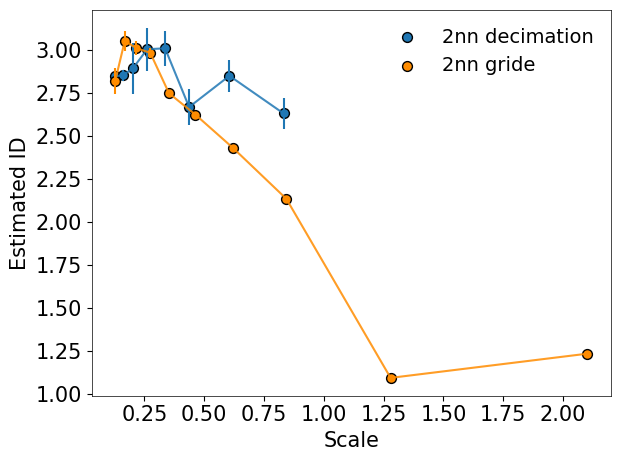

In [21]:
# Intrinsic dimension scaling analysig using two different methods
ids_2nn, errs_2nn, scales_2nn = d_best3.return_id_scaling_2NN()
ids_gride, errs_gride, scales_gride = d_best3.return_id_scaling_gride(range_max=1024)

col = 'darkorange'
plt.plot(scales_2nn, ids_2nn, alpha=0.85)
plt.errorbar(scales_2nn, ids_2nn, errs_2nn, fmt='None')
plt.scatter(scales_2nn, ids_2nn, edgecolors='k',s=50,label='2nn decimation')
plt.plot(scales_gride, ids_gride, alpha=0.85, color=col)
plt.errorbar(scales_gride, ids_gride, errs_gride, fmt='None',color=col)
plt.scatter(scales_gride, ids_gride, edgecolors='k',color=col,s=50,label='2nn gride')
plt.xlabel(r'Scale',size=15)
plt.ylabel('Estimated ID',size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(frameon=False,fontsize=14)
plt.tight_layout()

In [22]:
# estimate density via PAk
d_best3.set_id(3.)
d_best3.compute_density_PAk()

# cluster data via Advanced Density Peak
d_best3.compute_clustering_ADP(Z=2.0,halo=False);
n_clusters = len(d_best3.cluster_centers)
print(n_clusters)

3


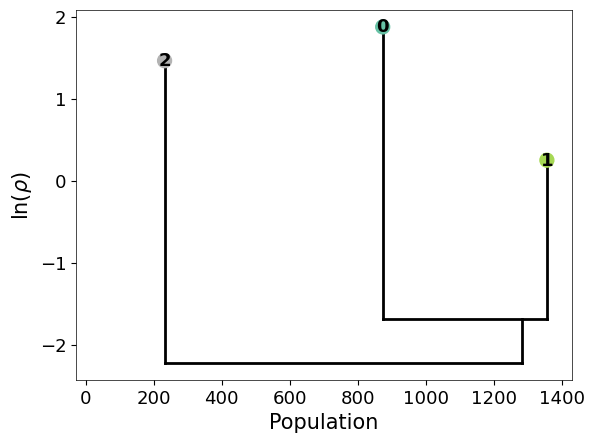

In [23]:
pl.get_dendrogram(d_best3, cmap='Set2', logscale=False)

In [24]:
# Cluster populations
populations = [ len(el) for r_,el in enumerate(d_best3.cluster_indices)]
print(populations)

[818, 147, 464]


In [25]:
# Cluster centers. In the original trajecotory these frames are given by (center + 400) * 10
print(d_best3.cluster_centers)
print("For the trajectory use frames: ",np.array(d_best3.cluster_centers)*28 + 1580)

[196, 639, 942]
For the trajectory use frames:  [ 7068 19472 27956]


In [26]:
# what is the RGYR, PC1, PC2 value of the cluster center of beta pin and loop?
print(best3[196])
print(best3[942])

[ 7.25 -1.17 -0.04]
[6.55 1.01 0.9 ]


In [27]:
#Free energy
W = - d_best3.log_den 
#np.savetxt('./FREE_ENERGY_CLUSTER/MATLAB/best3_free_energy_1429pt.txt', W)

#### For making a isosurface (in Free Energy) rendering in Matlab, map the data to a grid

In [ ]:
# map my values to a uniform, ordered grid!

X = best3[:,0] #RGYR
Y = best3[:,1] #PC1
Z = best3[:,2] #PC2
W = - d_best3.log_den #Free energy

## make regular grid to use below with marching cubes instead of Matlab
XX,YY,ZZ = np.mgrid[X.min():X.max():110j, Y.min():Y.max():110j, Z.min():Z.max():110j]
newdata = griddata( best3, W, (XX,YY,ZZ) , method='linear', rescale=True)

mygrid = np.concatenate((XX.flatten()[:,np.newaxis], YY.flatten()[:,np.newaxis], ZZ.flatten()[:,np.newaxis], newdata.flatten()[:,np.newaxis]), axis=1)

#### The publication image was rendered in matlab. Below an alternative rendering
The matlab script is in folder FREE_ENERGY_CLUSTER/MATLAB as "matlab_free_energy_plot_script" and below

In [ ]:
# # FOR MATLAB

# close all
# clear all
# hold off
# NGRID=130;
# xx=load('../best3_scaled_rgyr_pc1_pc2_1429pt.txt');
# ff=load('./best3_free_energy_1429pt.txt');
# x=xx(:,1);
# y=xx(:,2);
# z=xx(:,3);
# [minx,maxx] = bounds(x);
# [miny,maxy] = bounds(y);
# [minz,maxz] = bounds(z);
# [xq,yq,zq] = meshgrid(linspace(minx,maxx,NGRID),linspace(miny,maxy,NGRID),linspace(minz,maxz,NGRID));
# f=ff(:,1)*2.479;
# fq = griddata(x,y,z,f,xq,yq,zq,'natural');
# patch(isosurface(xq,zq,yq,fq, 9.),'FaceColor','red','FaceAlpha',0.1,'EdgeColor','none');
# patch(isosurface(xq,zq,yq,fq, 4.),'FaceColor','blue','FaceAlpha',0.3,'EdgeColor','none');
# patch(isosurface(xq,zq,yq,fq, -0.25),'FaceColor','blue','FaceAlpha',1.,'EdgeColor','none');
# camlight;
# campos([-15.2,-17.8,10.8]);
# view(-52.3,22.7);
# camtarget([7.8,-0.049,0.104]);
# camup([0 0 1]);
# camva(9.66);
# light("Style","local","Position",[-17,-29,15]);
# xlabel('RGYR'); ylabel('PC2'); zlabel('PC1');
# grid on;
# set(gca,'FontName','Helvetica','FontSize',12);
# lgd = legend(' 9.0 kJ/mol',' 4.0 kJ/mol','-0.25 kJ/mol');
# title(lgd,'Free energy')
# lighting gouraud


In [ ]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes(newdata, 0)
verts2, faces2, normals2, values2 = measure.marching_cubes(newdata, 2)
verts3, faces3, normals3, values3 = measure.marching_cubes(newdata, 5)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

mesh2 = Poly3DCollection(verts2[faces2])
mesh2.set(facecolor='r', alpha=0.3)
ax.add_collection3d(mesh2)

mesh3 = Poly3DCollection(verts3[faces3])
mesh3.set(alpha = 0.2)
ax.add_collection3d(mesh3)

mesh = Poly3DCollection(verts[faces])

mesh.set(facecolor='r', alpha=0.6)
ax.add_collection3d(mesh)
ax.set_xlabel("RGYR")
ax.set_ylabel("PC1")
ax.set_zlabel("PC2")
ax.set_xlim(0,80)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0,80)  # b = 10
ax.set_zlim(0,80)  # c = 16
plt.tight_layout()
plt.show()

## All heavy atom distances

In [28]:
heavy_atom_distances = dis

In [29]:
d_distances = Data(heavy_atom_distances,verbose=False)
d_distances.compute_distances(maxk=min(heavy_atom_distances.shape[0]-1,10000))
d_distances.compute_id_2NN()

(12.141824752591557, 0.0, 7.66886525941196)

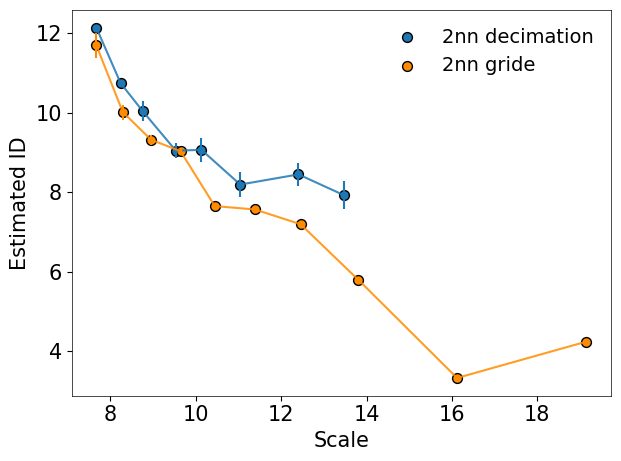

In [30]:
# ID scaling analysig using two different methods
ids_2nn, errs_2nn, scales_2nn = d_distances.return_id_scaling_2NN()
ids_gride, errs_gride, scales_gride = d_distances.return_id_scaling_gride(range_max=1024)

col = 'darkorange'
plt.plot(scales_2nn, ids_2nn, alpha=0.85)
plt.errorbar(scales_2nn, ids_2nn, errs_2nn, fmt='None')
plt.scatter(scales_2nn, ids_2nn, edgecolors='k',s=50,label='2nn decimation')
plt.plot(scales_gride, ids_gride, alpha=0.85, color=col)
plt.errorbar(scales_gride, ids_gride, errs_gride, fmt='None',color=col)
plt.scatter(scales_gride, ids_gride, edgecolors='k',color=col,s=50,label='2nn gride')
plt.xlabel(r'Scale',size=15)
plt.ylabel('Estimated ID',size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(frameon=False,fontsize=14)
plt.tight_layout()

In [31]:
# estimate density via PAk
d_distances.set_id(8.)
d_distances.compute_density_PAk()
# cluster data via Advanced Density Peak
d_distances.compute_clustering_ADP(Z=2.6,halo=False);
n_clusters = len(d_distances.cluster_centers)
print(n_clusters)

4


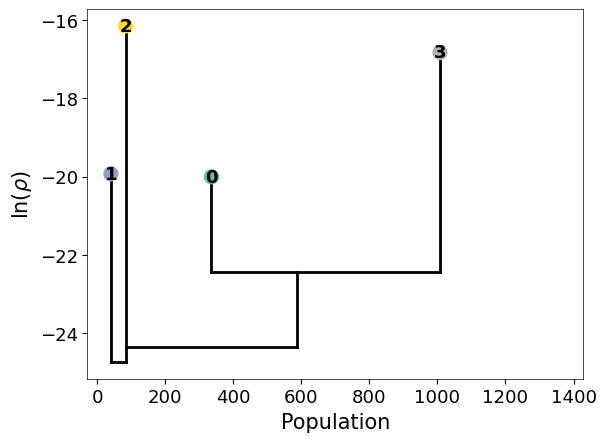

In [32]:
pl.get_dendrogram(d_distances, cmap='Set2', logscale=False)

In [33]:
# Cluster populations
populations = [ len(el) for r_,el in enumerate(d_distances.cluster_indices)]
print(populations)

[500, 81, 5, 843]


In [34]:
# Cluster centers: In original trajecotory: (center + 400) * 10
print(d_distances.cluster_centers)
print("For the trajectory use frames: ",np.array(d_distances.cluster_centers)*28 + 1580)

[250, 738, 768, 1067]
For the trajectory use frames:  [ 8580 22244 23084 31456]


## Check equivalence of the two data descriptions
- The cluster indices are not aligned from the two represebtations and have to be aligned until purity is maximized

In [35]:
# permutation of cluster assignment: 2 -> 1 and 1 -> 2
distances_cluster_assignments_2 = np.copy(d_distances.cluster_assignment)

zeros = np.where(d_distances.cluster_assignment == 0)
ones = np.where(d_distances.cluster_assignment == 1)
twos = np.where(d_distances.cluster_assignment == 2)
threes = np.where(d_distances.cluster_assignment == 3)


distances_cluster_assignments_2[threes] = 0
distances_cluster_assignments_2[zeros] = 2
distances_cluster_assignments_2[twos] = 1
distances_cluster_assignments_2[ones] = 0
# number of elements in common after permutation
print("purity beta-loop cluster", sum(distances_cluster_assignments_2 == d_best3.cluster_assignment)/d_best3.N)
print("purity intermediate cluster", len(set(list(np.where(d_best3.cluster_assignment == 0)[0])).intersection(np.where(distances_cluster_assignments_2 == 0)[0]))/len(np.where(distances_cluster_assignments_2 == 0)[0]))
print("purity collapsed loop cluster", len(set(list(np.where(d_best3.cluster_assignment == 2)[0])).intersection(np.where(distances_cluster_assignments_2 == 2)[0]))/len(np.where(distances_cluster_assignments_2 == 2)[0]))

purity beta-loop cluster 0.8894331700489853
purity intermediate cluster 0.8712121212121212
purity collapsed loop cluster 0.922
